# Image Caption Generator
This process aims to create a model capable of auto-generating an image caption from the features within the photo. 

## Business Understanding
[...]

## Data Understanding
The dataset leveraged throughout this process is the Flickr8k dataset.  

### Resources:
1. The following [post](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/) discussing implementation of an auto-caption generator in Keras. 
2. Download the Flickr30k dataset [here](https://www.kaggle.com/datasets/adityajn105/flickr8k) 

#### Load Dependencies

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import os
import glob
from nltk import word_tokenize
from PIL import Image
from time import time
from tensorflow import keras
from keras import Input, layers, optimizers
from keras.preprocessing import sequence, image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
# ensure access to gpu
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# set up filepath for text file
caption_path = '/Users/addingtongraham/Documents/datasets/Flickr8k/'
img_path = '/Users/addingtongraham/Documents/datasets/Flickr8k/Images/'

In [4]:
# load first few lines of captions.txt
captions = open(caption_path+'captions.txt', 'r').read()

# print first 10 lines
print(captions.split('\n')[:10])

['image,caption', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .']


We get a list of our images, the captions, and the format of each image. Looking at the above, we can see that there are a number of descriptions presented for each image. For this reason, we will parse all the captions, and set up a dictionary with imageID as keys, and various captions as the values. 

We can also see that the first item in `captions.split('\n')` can be dropped as it looks like a header

In [5]:
# drop first item
split_captions = captions.split('\n')[1:]
split_captions[:10]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .']

In [6]:
line = split_captions[1]
tokens = word_tokenize(line)
tokens[0]

'1000268201_693b08cb0e.jpg'

With the first, nonsensical item in the list removed, will want to enter the file_id as a key in a dictionary, with all descriptions held as the value in a list.

In [7]:
caption_dict = {}
for line in split_captions:
    
    # ensure line is longer than 2 chars
    if len(line) > 2:
        
        # generate tokens
        tokens = word_tokenize(line)
        img_id = tokens[0]
        
        # regenerate string as lowercase
        img_caption = ' '.join(tokens[1:]).lower() 
        
        # remove punctuation
        img_caption = re.sub(r'[^\w\s]', '', img_caption)

        # check if the id is already in the dictionary 
        if img_id not in caption_dict:

            # add to dictionary if not in already
            caption_dict[img_id] = []

        # append description to appropriate id
        caption_dict[img_id].append(img_caption) # to lowercase

In [8]:
# check this worked
print(caption_dict['1000268201_693b08cb0e.jpg'])
print('\n', caption_dict['1001773457_577c3a7d70.jpg'])

[' a child in a pink dress is climbing up a set of stairs in an entry way ', ' a girl going into a wooden building ', ' a little girl climbing into a wooden playhouse ', ' a little girl climbing the stairs to her playhouse ', ' a little girl in a pink dress going into a wooden cabin ']

 [' a black dog and a spotted dog are fighting', ' a black dog and a tricolored dog playing with each other on the road ', ' a black dog and a white dog with brown spots are staring at each other in the street ', ' two dogs of different breeds looking at each other on the road ', ' two dogs on pavement moving toward each other ']


With all captions in a dictionary, let's load an image and corresponding captions to see what the actual image is.

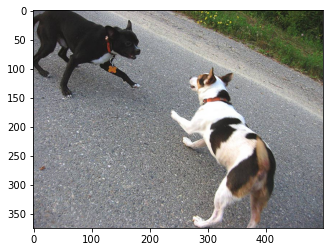

[' a black dog and a spotted dog are fighting',
 ' a black dog and a tricolored dog playing with each other on the road ',
 ' a black dog and a white dog with brown spots are staring at each other in the street ',
 ' two dogs of different breeds looking at each other on the road ',
 ' two dogs on pavement moving toward each other ']

In [9]:
# visualize image and captions
imgID1 = '1001773457_577c3a7d70.jpg'
x = plt.imread(img_path+imgID1)
plt.imshow(x)
plt.show()

# show captions
caption_dict[imgID1]

### Create Vocabulary 
With our captions and img IDs loaded into a dictionary, we can move forward with some additional text processing to get the unique vocabulary. 

In [10]:
# raw vocab size before any preprocessing
vocab = set()
for k in caption_dict.keys():
    [vocab.update(d.split()) for d in caption_dict[k]]
print('Vocab Size: %d' % len(vocab))

Vocab Size: 8827


We can see after processing captions to remove punctuation and convert everything to lowercase, we can see there are 8,827 unique words in our total dataset.

### Create Training and Test Sets
We know we have 8000 images in the total dataset.  To create a training set with roughly 80% / 20% split, we wil pull out the first 6400 images for our training set and keep the remaining images for validation and testing.

In [11]:
# confirm there are 8000 images
len(caption_dict)

8092

Looks like there are just over 8000 images in the total dataset, can move forward with pulling out 6400 for the training set.

In [12]:
# separate out training and testing sets
training_ids = list(caption_dict.items())[:6400]
test_ids = list(caption_dict.items())[6400:]

In [13]:
# create train sets 
train_captions = {}
for identifier in training_ids:
    img_id = identifier[0]
    captions = identifier[1]
    
    # add to dictionary
    train_captions[img_id] = captions

In [14]:
# add startseq and endseq 
for img_id, captions in train_captions.items():
    for idx, caption in enumerate(captions):
        captions[idx] = 'startseq ' + caption + ' endseq'

In [15]:
# create testing sets
test_captions = {}
for identifier in test_ids:
    img_id = identifier[0]
    captions = identifier[1]
    
    # add to dictionary
    test_captions[img_id] = captions

In [16]:
# calc vocab size of training set
train_vocab = set()
for k in train_captions.keys():
    [train_vocab.update(d.split()) for d in train_captions[k]]
print('Vocab Size of Train Set: %d' % len(train_vocab))

Vocab Size of Train Set: 7979


In [17]:
# calc vocab size of test set
test_vocab = set()
for k in test_captions.keys():
    [test_vocab.update(d.split()) for d in test_captions[k]]
print('Vocab Size of Test Set: %d' % len(test_vocab))

Vocab Size of Test Set: 4166


### Reduce Vocab Size to Frequent Words Only
To improve robustness of results, only include words that appear in the dataset more than 10 times.

In [18]:
# pull out all captions in train_captions
captions_train = []
for k,v in train_captions.items():
    for lst in v:
        captions_train.append(lst)

# preview captions_train
captions_train[:2]

['startseq  a child in a pink dress is climbing up a set of stairs in an entry way  endseq',
 'startseq  a girl going into a wooden building  endseq']

In [19]:
# reduce word_count to those appearing more than 10 times
thresh = 10
word_counts = {}
for capt in captions_train:
    for word in capt.split():
        word_counts[word] = word_counts.get(word, 0) + 1

new_vocab = [i for i in word_counts if word_counts[i] >= thresh]

print(f'New Vocab size: {len(new_vocab)}')

New Vocab size: 1735


### Word & Index Mapping

In [20]:
# append 1 to vocab since we append 0's to make all captions of equal length

In [21]:
idx_to_word = {}
word_to_idx = {}
idx = 1
for w in new_vocab:
    idx_to_word[idx] = w
    word_to_idx[w] = idx
    idx += 1

vocab_size = len(idx_to_word) + 1

In [22]:
vocab_size

1736

In [23]:
# find max length of captions, can't have arbitrary lengths
all_capts = []

for k in train_captions.keys():
    [all_capts.append(capt) for capt in train_captions[k]]

max_length = max(len(capt.split()) for capt in all_capts)
max_length

38

### Glove Embeddings

In [24]:
def glove_vectors(vocab):
    """
    Returns appropriate vectors from GloVe file.
    Input: vocabulary set to use.
    """
    glove = {}
    path = '/Users/addingtongraham/Documents/datasets/glove/glove.6B.50d.txt'
    with open(path, 'rb') as f:
        for line in f:
            parts = line.split()
            word = parts[0].decode('utf-8')
            if word in vocab:
                vector = np.array(parts[1:], dtype=np.float32)
                glove[word] = vector
    return glove

In [25]:
glove = glove_vectors(new_vocab)

In [26]:
# we now have a dict of words in vocab and vectors
# check how things look
glove['dog']

array([ 0.11008  , -0.38781  , -0.57615  , -0.27714  ,  0.70521  ,
        0.53994  , -1.0786   , -0.40146  ,  1.1504   , -0.5678   ,
        0.0038977,  0.52878  ,  0.64561  ,  0.47262  ,  0.48549  ,
       -0.18407  ,  0.1801   ,  0.91397  , -1.1979   , -0.5778   ,
       -0.37985  ,  0.33606  ,  0.772    ,  0.75555  ,  0.45506  ,
       -1.7671   , -1.0503   ,  0.42566  ,  0.41893  , -0.68327  ,
        1.5673   ,  0.27685  , -0.61708  ,  0.64638  , -0.076996 ,
        0.37118  ,  0.1308   , -0.45137  ,  0.25398  , -0.74392  ,
       -0.086199 ,  0.24068  , -0.64819  ,  0.83549  ,  1.2502   ,
       -0.51379  ,  0.04224  , -0.88118  ,  0.7158   ,  0.38519  ],
      dtype=float32)

Word embeddings are pretty powerful, because they allow us to relate items with different spellings that should be related. For example, we would expect the word vectors for `dog` to be more similar to the word vector for `cat` than to `shirt`.  We can take the mean of the word vectors to highlight this.

In [27]:
# get word vectors from glove for the following words
dog_vect = np.mean(glove['dog'])
cat_vect = np.mean(glove['cat'])
shirt_vect = np.mean(glove['shirt'])

In [28]:
# display differences and similarities
print(f'Mean of dog vector: {dog_vect}')
print(f'Mean of cat vector: {cat_vect}')
print(f'Mean of shirt vector: {shirt_vect}')

Mean of dog vector: 0.04934944212436676
Mean of cat vector: 0.04839027300477028
Mean of shirt vector: -0.18394270539283752


In [29]:
# create matrix consisting of vocab and 50-dimensional vector
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_to_idx.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [30]:
# pickle embedding matrix so can be accessed by lambda labs gpu
import pickle

with open('embedding_matrix.pickle', 'wb') as f:
    pickle.dump(embedding_matrix, f)

### Transfer Learn with InceptionV3

In [31]:
model = InceptionV3(weights='imagenet')

2022-04-20 19:53:56.769038: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-20 19:53:56.769362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [32]:
# remove softmax layer as we do not need to classify images
# just need to extract image vector for images
model_new = Model(model.input, model.layers[-2].output)

In [33]:
# pull out training ids
train_ids = [tup[0] for tup in training_ids]
train_ids[:2]

['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg']

In [34]:
test_ids = [tup[0] for tup in test_ids]
test_ids[:2]

['358607894_5abb1250d3.jpg', '3586239953_da4fb3f775.jpg']

In [35]:
# pre-process input to reshape images to (299 x 299)
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [36]:
# encode training and test images
# extract the images vectors
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

The process for encoding images is listed below.  Given large runtimes, after the first execution of this code, the related encoded images were saved into pickle files to enable quicker loading in the future

In [37]:
# encode training data
# Warning -- this will take several hours to complete
# encoding_train = {}
# for img_id in train_ids:
#     encoding_train[img_id] = encode(img_path+img_id)
# train_feats = encoding_train

In [38]:
# len(encoding_train)

In [39]:
# # remove error file and start running at 3487
# issue_idx = train_ids.index('294549892_babb130543.jpg,2')
# issue_idx

In [40]:
# train_ids[issue_idx] = '294549892_babb130543.jpg'

In [41]:
# # check for any more issues
# issues = []
# for filename in train_ids:
#     for char in filename:
#         if char == ',':
#             issues.append(filename)

In [42]:
# issues

In [43]:
# # re run starting at index 3486
# for img_id in train_ids[issue_idx:]:
#     encoding_train[img_id] = encode(img_path+img_id)
# train_feats = encoding_train

In [44]:
# # encode testing data
# encoding_test = {}
# pct_complete = 0
# for img_id in test_ids:
#     encoding_test[img_id] = encode(img_path+img_id)
#     pct_complete += 1
#     print(pct_complete/len(test_ids))
# test_feats = encoding_test

In [45]:
# # pickle training feats given long run times
# import pickle
# with open('training_feats.pickle', 'wb') as f:
#     pickle.dump(train_feats, f)

In [46]:
# # pickle testing feats
# with open('test_feats.pickle', 'wb') as f:
#     pickle.dump(test_feats, f)

### Load Encoded Images

In [47]:
# import pickle
import pickle

# load encoded training images
with open('training_feats.pickle', 'rb') as f:
    train_imgs_encoded = pickle.load(f)
    
# load encoded testing images
with open('test_feats.pickle', 'rb') as f:
    test_imgs_encoded = pickle.load(f)

### Define Model
As discussed in this [guide](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/), we will be creating a Merge model. 

This merge model will combine the image vector and partial captions. 

Model will have 3 steps:
1. Processing the sequence from the text
2. Extracting the feature vector from the image
3. Decoding the output using softmax by concatenating the above two layers

In [48]:
# calc input shape
input_shape = len(train_imgs_encoded['1000268201_693b08cb0e.jpg'])
print(input_shape)

2048


In [49]:
# create model inputs
inputs1 = Input(shape=(input_shape,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

In [50]:
# create inputs 2
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

In [51]:
# create decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [52]:
# creat model and model summary
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 50)       86800       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

### Model Training

In [53]:
# do not retrain weights in embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [54]:
# compile model using categorical_crossentropy as loss function
# adam as optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [55]:
# train in batches
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [56]:
# # train model for 30 epochs with batch size of 3 and 2000 steps per epoch
# epochs = 30
# batch_size = 3
# steps = len(train_captions) // batch_size

# generator = data_generator(train_captions, train_imgs_encoded, word_to_idx, max_length, batch_size)
# model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

In [57]:
# load trained model
with open('trained_model.pickle', 'rb') as f:
    trained_model = pickle.load(f)

2022-04-20 19:54:27.956331: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-20 19:54:28.078296: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-20 19:54:30.809982: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-20 19:54:30.833037: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-20 19:54:30.865382: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

### Greedy and Beam Search

In [64]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [69]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_to_idx["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx_to_word[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

### Evaluation

In [73]:
test_img = '358607894_5abb1250d3.jpg'
image = test_imgs_encoded[test_img].reshape((1,2048))

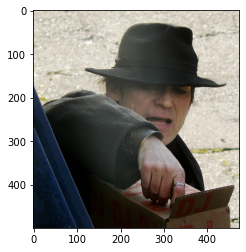

In [74]:
x = plt.imread(img_path+test_img)
plt.imshow(x)
plt.show()

In [75]:
print('Greedy Search:', greedySearch(image))
print('Beam Search, K=3:', beam_search_predictions(image, beam_index=3))

Greedy Search: town carnival carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival town carnival
Beam Search, K=3: town town town town town town town town town town town town town town town town town town town town town town town town town town town town town town town town town town town carnival carnival
